In [1]:
import pyam
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection
import string

from scipy.stats import pearsonr

from pathlib import Path

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Step 1: Read in the necessary data prepared in notebooks `101_prepare_input_data.ipynb` and `102_prepare_policy_categories.ipynb`

In [3]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


<IPython.core.display.Javascript object>

In [4]:
delay_categories = pd.read_excel(
    Path(
        '../data/102_delay_categories.xlsx'
    ),
    index_col=[0,1]
)

<IPython.core.display.Javascript object>

Step 2: Pull put the CDR variables.

In [5]:
cdr_variables = [
    x for x in df.variable if 'Carbon Removal' in x
]
cdr_variables

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total']

<IPython.core.display.Javascript object>

In [6]:
df_cdr = (
    df
    .filter(
        variable=cdr_variables,
        region='World'
    )
)

<IPython.core.display.Javascript object>

In [7]:
df_wo_cdr = (
    df
    .filter(
        variable=set(df.variable) - set(cdr_variables),
        region='World'
    )
)

<IPython.core.display.Javascript object>

Step 3: Convert the unit for CDR to ensure we get a consistent estimate.

In [8]:
df_cdr.convert_unit(
    current='Gt CO2/yr',
    to='Gt CO2/yr',
    factor=-1,
    inplace=True
)

<IPython.core.display.Javascript object>

Step 4: Filter the necessary variables for the assessment.

In [9]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
    'AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only'
]

<IPython.core.display.Javascript object>

In [10]:
df_wo_cdr.filter(
    variable=variables,
    inplace=True
)

<IPython.core.display.Javascript object>

Step 5: Compile the necessary data for our assessment

In [11]:
compiled_data_magnitude = pyam.concat(
    [
        df_cdr,
        df_wo_cdr
    ]
)

<IPython.core.display.Javascript object>

In [12]:
compiled_data_magnitude.filter(
    year=range(2020, 2101),
    inplace=True
)

<IPython.core.display.Javascript object>

Step 6: Calculate the offset from 2020.

In [13]:
compiled_data_magnitude_offset = (
    compiled_data_magnitude
    .offset(year=2020)
)

<IPython.core.display.Javascript object>

Step 7: Pull out the total mitigation effort.

In [14]:
total_mitigation_effort = 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only'

<IPython.core.display.Javascript object>

In [15]:
total_mitigation = (
    compiled_data_magnitude
    .filter(
        variable=total_mitigation_effort,
        region='World'
    )
    .timeseries()
    .reset_index()
    .drop(
        columns=[
            'variable',
            'region',
            'unit'
        ]
    )
    .set_index(
        [
            'model',
            'scenario'
        ]
    )
)

<IPython.core.display.Javascript object>

In [16]:
netzero_co2 = 'Year of netzero CO2 emissions (Harm-Infilled) table'
netzero_ghg = 'Year of netzero GHG emissions (Harm-Infilled) table'

<IPython.core.display.Javascript object>

In [17]:
compiled_data_magnitude_offset.meta = compiled_data_magnitude.meta

<IPython.core.display.Javascript object>

Step 8: Read in the delay categories. This will be important for panel d and e of the figure.

In [18]:
panel_bc = pd.concat(
    [
        compiled_data_magnitude.meta,
        delay_categories
    ],
    axis=1
)

<IPython.core.display.Javascript object>

In [19]:
panel_bc['category_reductions'] = panel_bc['category_reductions'].astype('category')
panel_bc['category_netzero'] = panel_bc['category_netzero'].astype('category')

<IPython.core.display.Javascript object>

In [20]:
panel_bc.loc[:, 'median_peak_warming'] = panel_bc.loc[:, 'Median peak warming (MAGICCv7.5.3)']

<IPython.core.display.Javascript object>

Step 9: Pull out the necessary data for panel f.
First, we need the cumulative non CO2 reductions from the year of net zero CO2 to 2100.

In [21]:
compiled_data_magnitude.meta.loc[:, netzero_co2] = compiled_data_magnitude.meta.loc[:, netzero_co2].fillna(2100)

<IPython.core.display.Javascript object>

In [22]:
nonco2 = (
    compiled_data_magnitude
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only'
    )
    .timeseries()
)

<IPython.core.display.Javascript object>

In [23]:
compiled_data_magnitude.set_meta(
    meta=nonco2.apply(
        lambda x: pyam.cumulative(
            x,
            first_year=compiled_data_magnitude.meta.loc[x.name[0:2], netzero_co2],
            last_year=2100
        ),
        axis=1
    ),
    name='cumulative_nonco2_netzero_2100'
)

<IPython.core.display.Javascript object>

Step 10: Compile the elements used in panel f.

In [24]:
panel_d = (
    compiled_data_magnitude
    .meta[
        [
            'cumulative_cdr_netzero_2100',
            'cumulative_gross_netzero_2100',
            'cumulative_nonco2_netzero_2100',
            'Median peak warming (MAGICCv7.5.3)',
            'Median warming in 2100 (MAGICCv7.5.3)'
        ]
    ]
)

<IPython.core.display.Javascript object>

In [25]:
panel_d.loc[:,'t_decline'] = (
    panel_d.loc[:, 'Median peak warming (MAGICCv7.5.3)']
    -
    panel_d.loc[:, 'Median warming in 2100 (MAGICCv7.5.3)']
)

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_3403/3337680351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_d.loc[:,'t_decline'] = (


<IPython.core.display.Javascript object>

In [26]:
offset_variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
    'AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only'   
]

<IPython.core.display.Javascript object>

In [27]:
panel_a_offset = (
    compiled_data_magnitude_offset
    .filter(
        variable=offset_variables
    )
)

<IPython.core.display.Javascript object>

In [28]:
categories_and_colors = {
    'C1':'#4dbdab',
    'C2':'#7688ab',
    'C3':'#e74d4d'
}

<IPython.core.display.Javascript object>

In [29]:
compiled_data_magnitude.meta.loc[:, netzero_co2]=compiled_data_magnitude.meta.loc[:, netzero_co2].fillna(2100)

<IPython.core.display.Javascript object>

In [30]:
year_columns = [
    (2020, 2030),
    (2030, 2050),
    (2050, 2100),
    (2100, 2100)
]

<IPython.core.display.Javascript object>

Read in the data for the third panel that we prepare in the notebook `104_prepare_netzero_for_figure2.ipynb`

In [31]:
mit_across_cats = pd.read_csv(
    Path(
        '../data/104_figure2_panelc.csv'
    ),
    index_col=[0,1]
)

<IPython.core.display.Javascript object>

In [32]:
mit_across_cats

2020  netzero Category     remove  \
model             scenario                                                     
AIM/CGE 2.0       SSP1-26                  51.0      3.0       C3  -7.675157   
                  SSP4-26                  58.0      7.0       C3  -7.395017   
AIM/CGE 2.1       CD-LINKS_NPi2020_1000    53.0      6.0       C3 -12.240858   
                  CD-LINKS_NPi2020_400     53.0     -3.0       C1 -16.143932   
                  CO_Bridge                55.0      7.0       C3  -7.373163   
...                                         ...      ...      ...        ...   
WITCH-GLOBIOM 4.4 CD-LINKS_INDC2030i_1600  54.0      5.0       C3 -12.900026   
                  CD-LINKS_NDC2030i_1000   54.0      4.0       C2  -9.897303   
                  CD-LINKS_NPi2020_1000    56.0      4.0       C1  -9.834387   
                  CD-LINKS_NPi2020_1600    56.0      5.0       C3 -10.857048   
                  CD-LINKS_NPi2020_400     56.0      4.0       C1  -8.520957   

                                              reduce  
model             scenario                            
AIM/CGE 2.0       SSP1-26                 -39.924308  
                  SSP4-26                 -43.153110  
AIM/CGE 2.1       CD-LINKS_NPi2020_1000   -35.431404  
                  CD-LINKS_NPi2020_400    -40.820973  
                  CO_Bridge               -40.490306  
...                                              ...  
WITCH-GLOBIOM 4.4 CD-LINKS_INDC2030i_1600 -36.657457  
                  CD-LINKS_NDC2030i_1000  -40.806546  
                  CD-LINKS_NPi2020_1000   -42.161808  
                  CD-LINKS_NPi2020_1600   -39.866954  
                  CD-LINKS_NPi2020_400    -44.066332  

[401 rows x 5 columns]

<IPython.core.display.Javascript object>

In [33]:
def _helper_plot_net(ax, df, x, col,  Category=None):
    if Category is None:
        plot_data = df
    else:
        plot_data = df[df['Category']==Category]
    ax.bar(
        x=x,
        height=plot_data[col].median(),
        color='grey',
        alpha=0.8,
        width=0.2
    )
    ax.errorbar(
        x=[x, x],
        y=[plot_data[col].quantile(q=0.25), plot_data[col].quantile(q=0.75)],
        color='black',
        marker='_'
    
    )
    if col=='2020':
        ax.axhline(plot_data[col].median(), color='grey', linestyle='--')
    return plot_data[col].median()

<IPython.core.display.Javascript object>

In [34]:
def _plot_across_cats(ax):
    # First plot the 2020 value
    val = _helper_plot_net(ax, mit_across_cats, 0, '2020')
    prev_med = dict()
    for i, Category in enumerate(['C1', 'C2', 'C3']):
        _ = _helper_plot_net(ax, mit_across_cats, i+1, 'netzero', Category=Category)
        prev_med[Category] = val

    # Now, per category, we want to plot the reductions.
    for i, Category in enumerate(['C1', 'C2', 'C3']):
        data = mit_across_cats[mit_across_cats['Category']==Category]
        ax.bar(
            x = i + 0.3,
            bottom=prev_med[Category], 
            height=data['reduce'].median(),
            width=0.2,
            color='#a9b2cb'
        )
        ax.errorbar(
            x=[i+0.3, i+0.3],
            y=[data['reduce'].quantile(q=0.25) + prev_med[Category], data['reduce'].quantile(q=0.75) + prev_med[Category]],
            color='black',
            marker='_'
        )
        prev_med[Category] += data['reduce'].median()
    for i, Category in enumerate(['C1', 'C2', 'C3']):
        data = mit_across_cats[mit_across_cats['Category']==Category]
        ax.bar(
            x = i + 0.6,
            bottom=prev_med[Category], 
            height=data['remove'].median(),
            width=0.2,
            color='#d35f27'
        )
        ax.errorbar(
            x=[i+0.6, i+0.6],
            y=[data['remove'].quantile(q=0.25) + prev_med[Category], data['remove'].quantile(q=0.75) + prev_med[Category]],
            color='black',
            marker='_'
        )

<IPython.core.display.Javascript object>

In [35]:
def plot_waterfall_reductions(ax, climate_category='C1'):
    """
    Helper function to plot out waterfall reduction components
    for a given climate category
    """

    scens = (
        compiled_data_magnitude
        .filter(Category=climate_category)
        .meta
        .index
    )
    small_total_mitigation = total_mitigation.loc[scens,:]

    variable_colors = {
        'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross':'#0773b1',
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total':'#d35f27',
        'AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only':'#cc79a7'     
    }

    prev_med = dict()
    for i, (start_year, end_year) in enumerate(year_columns):
        col_tot=start_year
        prev_med[start_year] = small_total_mitigation[col_tot].median()
        ax.bar(i, height=small_total_mitigation[col_tot].median(), color='grey', width=0.15)
        ax.errorbar(
            x=[i,i],
            y=[small_total_mitigation[col_tot].quantile(q=0.25), small_total_mitigation[col_tot].quantile(q=0.75)],
            color='black',
            marker='_',
            markersize=10,
            alpha=0.6
        )

        for j, var in enumerate(offset_variables):
            data = (
                compiled_data_magnitude
                .filter(
                    Category=climate_category,
                    variable=var,
                    year=range(start_year, end_year+1)
                )
                .offset(year=start_year)
                .timeseries()[end_year]
            )
            loc = i + ((j+1)*0.25)
            ax.bar(loc, bottom=prev_med[start_year], height=data.median(), width=0.15, color=variable_colors[var])
            # Now add the errorbars
            ax.errorbar(
                x=[loc, loc],
                y=[prev_med[start_year]+data.quantile(q=0.25), prev_med[start_year]+data.quantile(q=0.75)],
                color='black',
                marker='_',
                markersize=10,
                alpha=0.6
            )
            prev_med[start_year] = data.median() + prev_med[start_year]

    ax.axhline(0, color='grey', alpha=0.5)
    ax.set_xlim(-0.1, 3.1)
    ax.set_xticks(
        [0,1,2,3],
        [
            2020,
            2030,
            2050,
            2100
        ]
    )

    # Make and append a custom legend
    line = Line2D([],[], ls="none", color='black')
    barline = LineCollection(np.empty((2,2,2)), color='black')
    custom_legend = [
        Patch(facecolor='grey', edgecolor='grey', label='Net GHG emissions (direct)'),
        Patch(facecolor='#0773b1', edgecolor='#0773b1', label='Gross CO$_2$ reductions'),
        Patch(facecolor='#d35f27', edgecolor='#d35f27', label='Carbon dioxide removal (direct)'),
        Patch(facecolor='#cc79a7', edgecolor='#cc79a7', label='Non CO$_2$ [GWP100]'),
        ErrorbarContainer((line, [line], [barline]), has_yerr=True, label='Interquartile range')
    ]
    ax.legend(handles=custom_legend, framealpha=0.0)

    # return summary_stats

<IPython.core.display.Javascript object>

In [36]:
font = {
    'size' : 16,
    'family':'sans-serif',
    'sans-serif':'Arial'
}
plt.rc(
    'font', **font,
)

<IPython.core.display.Javascript object>

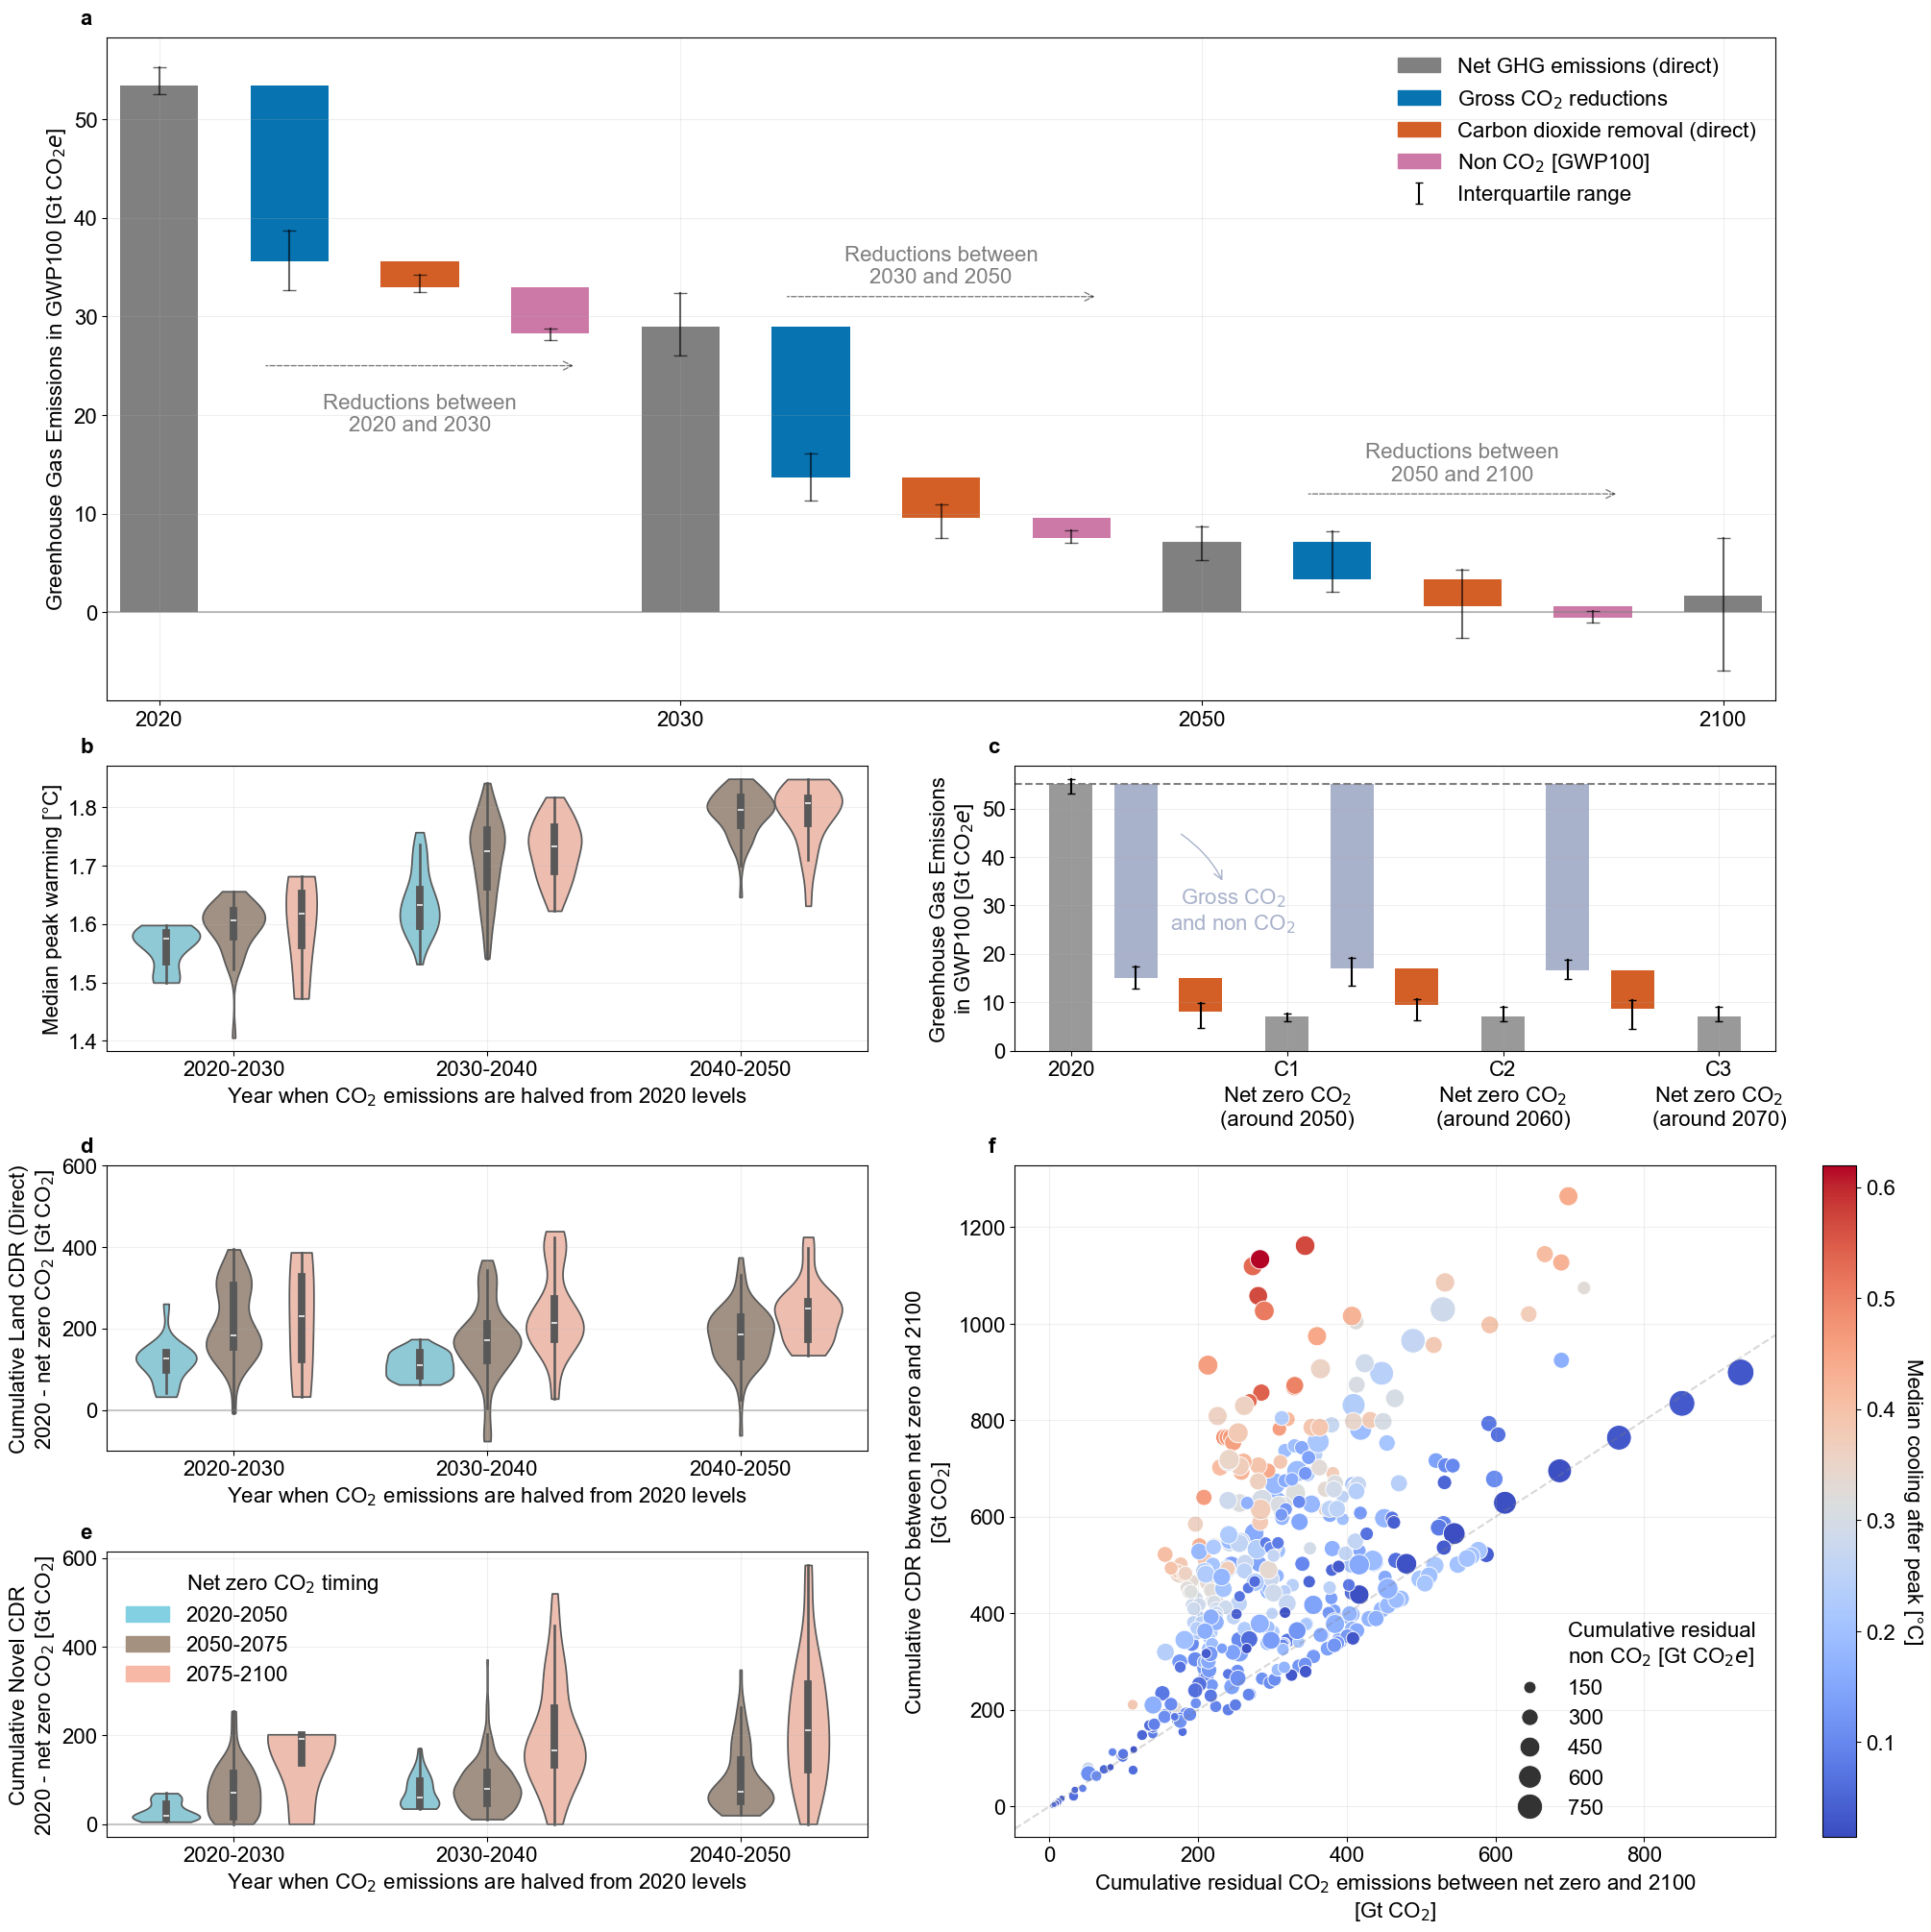

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplot_mosaic(
    [
        ['a', 'a'],
        ['a', 'a'],
        ['b','c'],
        ['d', 'f'],
        ['e', 'f']
    ],
    figsize=(20,20),
    constrained_layout=True
)

# PANEL A
plot_waterfall_reductions(
    ax=ax['a'],
    climate_category='C1'
)
ax['a'].set_ylabel('Greenhouse Gas Emissions in GWP100 [Gt CO$_2e$]')
ax['a'].annotate(
    '',
    xy=(0.2, 25),
    xytext=(0.8, 25),
    #xycoords='data',
    arrowprops=dict(
        arrowstyle='<-',
        linestyle='dashed',
        alpha=0.5
    )
)

ax['a'].annotate(
    'Reductions between\n2020 and 2030',
    xy=(0.5, 18),
    xytext=(0.5, 18),
    ha='center',
    va='bottom',
    alpha=0.5
)
ax['a'].annotate(
    'Reductions between\n2030 and 2050',
    xy=(1.5, 33),
    xytext=(1.5, 33),
    ha='center',
    va='bottom',
    alpha=0.5
)

ax['a'].annotate(
    '',
    xy=(1.2, 32),
    xytext=(1.8, 32),
    #xycoords='data',
    arrowprops=dict(
        arrowstyle='<-',
        linestyle='dashed',
        alpha=0.5
    )
)

ax['a'].annotate(
    'Reductions between\n2050 and 2100',
    xy=(2.5, 13),
    xytext=(2.5, 13),
    ha='center',
    va='bottom',
    alpha=0.5
)

ax['a'].annotate(
    '',
    xy=(2.2, 12),
    xytext=(2.8, 12),
    #xycoords='data',
    arrowprops=dict(
        arrowstyle='<-',
        linestyle='dashed',
        alpha=0.5
    )
)

# PANEL B
# In this panel, we plot the distribution of median peak warming across the different delay categories
warming = sns.violinplot(
    data=panel_bc,
    x='category_reductions',
    y='median_peak_warming',
    ax=ax['b'],
    cut=0,
    hue='category_netzero',
    palette=[
        '#83d0e2',
        '#a5917f',
        '#f7b9a6'
    ],
    legend=False
)
warming.set_xlabel('Year when CO$_2$ emissions are halved from 2020 levels')
warming.set_ylabel('Median peak warming [°C]')

# PANEL C
# In this panel, we plot the contrib
_plot_across_cats(ax['c'])
ax['c'].set_xticks(
    [0,1,2,3],
    [
        2020,
        'C1\nNet zero CO$_2$\n(around 2050)',
        'C2\nNet zero CO$_2$\n(around 2060)',
        'C3\nNet zero CO$_2$\n(around 2070)'
    ]

)
ax['c'].set_ylabel('Greenhouse Gas Emissions\nin GWP100 [Gt CO$_2e$]')

ax['c'].annotate(
    'Gross CO$_2$\nand non CO$_2$',
    xy=(0.5, 45),
    xytext=(0.75, 25),
    xycoords='data',
    textcoords='data',
    ha='center',
    color='#a9b2cb',
    arrowprops=dict(
        arrowstyle='<-',
        connectionstyle='arc3,rad=0.2',
        color='#a9b2cb'
    )
)


# PANEL D
b = sns.violinplot(
    data=panel_bc,
    x='category_reductions',
    y='land_cdr_2020_netzero',
    ax=ax['d'],
    hue='category_netzero',
    cut=0,
    palette=[
        '#83d0e2',
        '#a5917f',
        '#f7b9a6'
    ],
    legend=False

)

b.set_xlabel('Year when CO$_2$ emissions are halved from 2020 levels')
b.set_ylabel('Cumulative Land CDR (Direct)\n2020 - net zero CO$_2$ [Gt CO$_2$]')
ax['d'].axhline(0, color='grey', alpha=0.4)
ax['d'].set_ylim(-100, 600)

# PANEL E
c = sns.violinplot(
    data=panel_bc,
    x='category_reductions',
    y='novel_cdr_2020_netzero',
    ax=ax['e'],
    hue='category_netzero',
    palette=[
        '#83d0e2',
        '#a5917f',
        '#f7b9a6'
    ],
    cut=0,
    legend=False
)
c.set_xlabel('Year when CO$_2$ emissions are halved from 2020 levels')
c.set_ylabel('Cumulative Novel CDR\n2020 - net zero CO$_2$ [Gt CO$_2$]')
ax['e'].axhline(0, color='grey', alpha=0.4)

second_custom_legend = [
    Patch(facecolor='w', edgecolor='w', label='Net zero CO$_2$ timing'),
    Patch(facecolor='#83d0e2', edgecolor='#83d0e2', label='2020-2050'),
    Patch(facecolor='#a5917f', edgecolor='#a5917f', label='2050-2075'),
    Patch(facecolor='#f7b9a6', edgecolor='#f7b9a6', label='2075-2100'),
]
ax['e'].legend(handles=second_custom_legend, framealpha=0.0, ncol=1)

# PANEL F
d = sns.scatterplot(
    data=panel_d,
    ax=ax['f'],
    x='cumulative_gross_netzero_2100',
    y='cumulative_cdr_netzero_2100',
    hue='t_decline',
    size='cumulative_nonco2_netzero_2100',
    palette='coolwarm',
    sizes=(20, 400)
)

norm = plt.Normalize(
    panel_d['t_decline'].min(),
    panel_d['t_decline'].max()
)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
cbar = d.figure.colorbar(sm, ax=ax['f'])
cbar.ax.set_ylabel('Median cooling after peak [°C]', rotation=270, labelpad=20) 
ax['f'].axline((0, 0), (1, 1),color='grey', linestyle='dashed', alpha=0.3)
ax['f'].set_xlabel('Cumulative residual CO$_2$ emissions between net zero and 2100\n[Gt CO$_2$]')
ax['f'].set_ylabel('Cumulative CDR between net zero and 2100\n[Gt CO$_2$]')

h, l = d.get_legend_handles_labels()
#l[7] = 'Cumulative\ngross CO$_2$'
l[5] = 'Cumulative residual\nnon CO$_2$ [Gt CO$_2e$]'
ax['f'].legend(h[5:], l[5:], ncol=1, framealpha=0.0, loc=4)

# Handle grids and annotations for subplots
for lab,a in ax.items():
    a.grid(alpha=0.2)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    a.text(0.0, 1.0, lab, transform=a.transAxes + trans,
             va='bottom', weight='bold')

In [38]:
fig.savefig(
    Path(
        'figures/Figure1.png'
    ),
    dpi=400,
    bbox_inches='tight'
)

<IPython.core.display.Javascript object>

Now, we want to create a supplementary figure with the C2 and C3 categories to be referenced in the main text.

Text(0, 0.5, 'Greenhouse Gas Emissions\nin GWP100 [Gt CO$_2e$]')

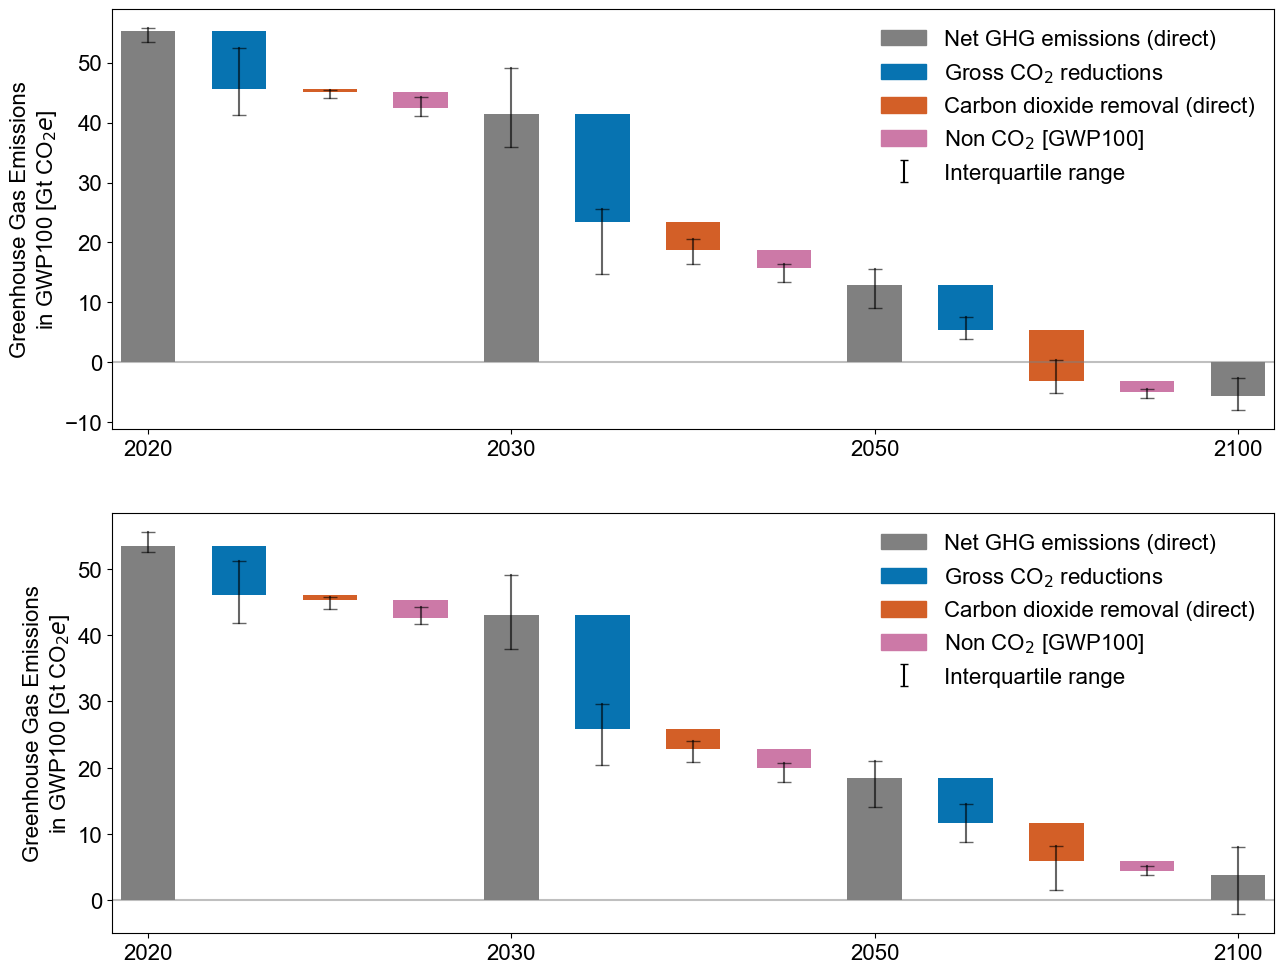

<IPython.core.display.Javascript object>

In [39]:
fig_si, ax_si = plt.subplot_mosaic(
    [
        ['a'],
        ['b']
    ],
    figsize=(15, 12)
)

# PANEL A
plot_waterfall_reductions(
    ax=ax_si['a'],
    climate_category='C2'
)

# PANEL A
plot_waterfall_reductions(
    ax=ax_si['b'],
    climate_category='C3'
)
ax_si['a'].set_ylabel('Greenhouse Gas Emissions\nin GWP100 [Gt CO$_2e$]')
ax_si['b'].set_ylabel('Greenhouse Gas Emissions\nin GWP100 [Gt CO$_2e$]')

In [40]:
fig_si.savefig(
    Path(
        'figures/SI_fig1.png'
    ),
    bbox_inches='tight',
    dpi=400
)

<IPython.core.display.Javascript object>

Step 12: Construct the summary statistics in Table 1.

In [41]:
stats = pyam.Statistics(
    df=df.filter(region='World'),
    filters=[
        ('C1', {'Category':'C1'}),
        ('C2', {'Category':'C2'}),
        ('C3', {'Category':'C3'})
    ],
    rows=True
)

<IPython.core.display.Javascript object>

In [42]:
compare_years = [
    (2020, 2030),
    (2020, 2035),
    (2020, 2050),
    (2020, 2100)
]

<IPython.core.display.Javascript object>

In [43]:
statistics_settings = dict(
    header='Level [Gt CO2]',
    header_change='Change from 2020',
    header_percent_change='% change from 2020',
    compare_years=compare_years,
    years=[2020, 2030, 2035, 2050, 2100]
)

<IPython.core.display.Javascript object>

Add a helper function to add the necessary statstics.

In [44]:
def add_statistics(data, row,years, compare_years,header, header_change, header_percent_change):
    stats.add(
        data[years],
        header=header,
        row=row
    )
    for i,j in compare_years:
        change = (data[j] - data[i])
        percent_change = (data[j] - data[i]) * 100 / data[i]
        #stats.add(
        #    change,
        #    header=header_change,
        #    row=row,
        #    subheader=f'{i}-{j}'
        #)
        stats.add(
            percent_change,
            header=header_percent_change,
            row=row,
            subheader=f'{i}-{j}'
        )

<IPython.core.display.Javascript object>

In [45]:
variable_label = [
    ('AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only', 'Net GHG (direct)'),
    ('AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross', 'Gross CO2 (direct)'),
    ('AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only', 'Non CO2'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total', 'CDR (direct)'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land', 'Novel CDR'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct', 'Conventional CDR')
]

<IPython.core.display.Javascript object>

In [46]:
for var, label in variable_label:
    data = (
        df
        .filter(
            variable=var,
            region='World'
        )
        .timeseries()
    )
    add_statistics(
        data,
        label,
        **statistics_settings
    )

/Users/gauravganti/opt/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/statistics.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _stats = _stats_f if _stats is None else _stats.append(_stats_f)
/Users/gauravganti/opt/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/statistics.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _stats = _stats_f if _stats is None else _stats.append(_stats_f)
/Users/gauravganti/opt/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/statistics.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _stats = _stats_f if _stats is None else _stats.append(_stats_f)
/Users/gauravganti/opt/anaconda3/envs/ar6_cdr_assessment/lib/python3.1

<IPython.core.display.Javascript object>

In [47]:
numbers = (
    stats
    .summarize(
        center='median',
        interquartile=True,
        custom_format='{:.1f}'
    )
    .round(1)
    #.swaplevel(0,1, axis=0)
    #.sort_index(level=0)
)


<IPython.core.display.Javascript object>

In [48]:
numbers

count     Level [Gt CO2]                     \
median (interquartile range)                     2020               2030   
C1 Net GHG (direct)             70  53.4 (55.2, 52.6)  28.9 (32.4, 26.0)   
   Gross CO2 (direct)           70  41.8 (43.7, 40.0)  24.5 (26.2, 21.1)   
   Non CO2                      70  14.8 (15.2, 14.0)    9.8 (10.8, 9.3)   
   CDR (direct)                 70     2.5 (2.5, 2.5)     5.1 (5.7, 3.9)   
   Novel CDR                    70     0.0 (0.0, 0.0)     0.3 (0.6, 0.1)   
   Conventional CDR             70     2.5 (2.5, 2.5)     4.0 (5.1, 3.4)   
C2 Net GHG (direct)            102  55.2 (55.7, 53.4)  41.5 (49.0, 36.0)   
   Gross CO2 (direct)          102  43.3 (43.9, 41.5)  33.5 (39.2, 28.4)   
   Non CO2                     102  14.3 (15.2, 13.8)  11.8 (13.4, 10.6)   
   CDR (direct)                102     2.5 (2.5, 2.5)     3.2 (4.1, 2.8)   
   Novel CDR                   102     0.0 (0.0, 0.0)     0.1 (0.2, 0.0)   
   Conventional CDR            102     2.5 (2.5, 2.5)     3.1 (3.8, 2.7)   
C3 Net GHG (direct)            229  53.5 (55.5, 52.5)  43.1 (49.1, 37.9)   
   Gross CO2 (direct)          229  42.1 (43.7, 40.0)  34.0 (39.3, 30.8)   
   Non CO2                     229  14.8 (15.3, 14.0)  12.2 (13.2, 11.0)   
   CDR (direct)                229     2.5 (2.5, 2.5)     3.2 (4.7, 2.7)   
   Novel CDR                   229     0.0 (0.0, 0.0)     0.0 (0.2, 0.0)   
   Conventional CDR            229     2.5 (2.5, 2.5)     3.2 (4.5, 2.5)   

                                                                    \
median (interquartile range)               2035               2050   
C1 Net GHG (direct)           21.1 (24.2, 18.5)     7.2 (8.7, 5.3)   
   Gross CO2 (direct)         18.1 (20.6, 16.1)    8.3 (10.1, 7.5)   
   Non CO2                       9.0 (9.9, 8.4)     7.6 (8.9, 6.7)   
   CDR (direct)                  6.1 (7.1, 4.9)    9.3 (11.5, 7.6)   
   Novel CDR                     1.0 (1.7, 0.3)     3.8 (5.7, 1.8)   
   Conventional CDR              4.8 (5.6, 3.9)     5.4 (6.3, 3.6)   
C2 Net GHG (direct)           31.4 (36.4, 27.9)   12.8 (15.5, 9.0)   
   Gross CO2 (direct)         26.2 (29.3, 22.5)  12.6 (16.1, 10.7)   
   Non CO2                     10.0 (11.0, 9.4)     8.2 (9.1, 7.7)   
   CDR (direct)                  4.5 (5.6, 3.5)    8.1 (10.5, 6.5)   
   Novel CDR                     0.3 (0.6, 0.1)     3.5 (5.8, 1.2)   
   Conventional CDR              4.0 (4.5, 3.1)     5.2 (5.7, 3.7)   
C3 Net GHG (direct)           34.5 (37.6, 29.5)  18.5 (21.1, 14.1)   
   Gross CO2 (direct)         28.1 (30.3, 24.8)  16.2 (18.3, 13.8)   
   Non CO2                     10.5 (11.4, 9.3)     8.6 (9.1, 7.2)   
   CDR (direct)                  4.1 (5.5, 3.2)     6.3 (9.4, 5.5)   
   Novel CDR                     0.2 (0.6, 0.1)     2.0 (3.6, 0.8)   
   Conventional CDR              3.6 (5.0, 2.5)     4.0 (5.5, 2.7)   

                                                      % change from 2020  \
median (interquartile range)               2100                2020-2030   
C1 Net GHG (direct)             1.7 (7.6, -5.9)     -47.5 (-38.9, -51.6)   
   Gross CO2 (direct)           5.5 (11.7, 3.9)     -43.1 (-35.3, -49.7)   
   Non CO2                       6.6 (7.6, 5.3)     -31.8 (-28.6, -35.1)   
   CDR (direct)                11.8 (17.1, 9.5)      105.7 (125.0, 56.5)   
   Novel CDR                    7.7 (12.6, 5.7)  nan (nan, 81189.9) [68]   
   Conventional CDR              3.6 (4.6, 2.2)       61.6 (100.2, 37.1)   
C2 Net GHG (direct)           -5.5 (-2.7, -8.0)      -25.1 (-9.4, -34.4)   
   Gross CO2 (direct)            5.3 (7.9, 4.0)      -22.3 (-6.7, -33.3)   
   Non CO2                       6.0 (7.1, 4.9)      -18.5 (-5.2, -27.0)   
   CDR (direct)               17.6 (19.9, 13.9)        25.3 (63.2, 12.5)   
   Novel CDR                  13.0 (15.8, 10.3)  nan (nan, 4119.8) [100]   
   Conventional CDR              3.5 (5.1, 2.4)        18.0 (54.0, 10.7)   
C3 Net GHG (direct)             3.8 (8.1, -

<IPython.core.display.Javascript object>

In [49]:
numbers.to_excel(
    Path(
        'figures/table1.xlsx'
    )
)

<IPython.core.display.Javascript object>

Statements: The contributions of non CO2 reductions and CDR between:
* 2020 - 2030 and
* 2030 - 2050

In [50]:
net_emissions = (
    compiled_data_magnitude
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only'
    )
    .timeseries()
)

<IPython.core.display.Javascript object>

In [51]:
start_end = [
    (2020, 2030),
    (2030, 2050)
]

<IPython.core.display.Javascript object>

In [52]:
for start, end in start_end:
    compiled_data_magnitude.set_meta(
        name=f'total_mitigation_{start}_{end}',
        meta=net_emissions[end] - net_emissions[start]
    )

<IPython.core.display.Javascript object>

In [53]:
compiled_data_magnitude.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only']

<IPython.core.display.Javascript object>

In [54]:
vars_of_interest = [
    ('AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross', 'gross'),
    ('AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only', 'nonco2'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total', 'cdr')
]

<IPython.core.display.Javascript object>

In [55]:
for start, end in start_end:
    for var, meta_label in vars_of_interest:
        ts = (
            compiled_data_magnitude
            .filter(
                variable=var
            )
            .offset(year=start)
            .timeseries()
        )
        proportion = ts.apply(
            lambda x: x[end] * 100 / (compiled_data_magnitude.meta.loc[x.name[0:2], f'total_mitigation_{start}_{end}']),
            axis=1
        )

        compiled_data_magnitude.set_meta(
            meta=proportion.round(0),
            name=f'{meta_label}_{start}_{end}'
        )

<IPython.core.display.Javascript object>

In [56]:
table_s1 = (
    compiled_data_magnitude
    .meta.groupby('Category')
    [['gross_2020_2030', 'nonco2_2020_2030', 'cdr_2020_2030', 'gross_2030_2050', 'nonco2_2030_2050', 'cdr_2030_2050']]
    .describe()
    .T
    .loc[
        pd.IndexSlice[:, ['25%', '50%', '75%']],
        :
    ]
    .unstack()
    .round(0)
)

<IPython.core.display.Javascript object>

In [57]:
table_s1_c1 = (
    table_s1
    .loc[
        :,
        pd.IndexSlice['C1', :]
    ]
    .droplevel(0, axis=1)
)

<IPython.core.display.Javascript object>

In [58]:
print(
    f"""
    In 1.5°C pathways (C1), most of the mitigation between 2020 and 2030 (Figure 1a) 
    is achieved through reducing gross CO2 emissions 
    ({table_s1_c1.loc['gross_2020_2030', '50%']} [{table_s1_c1.loc['gross_2020_2030', '25%']}, {table_s1_c1.loc['gross_2020_2030', '75%']}]) 
    and cutting non-CO2 emissions 
    ({table_s1_c1.loc['nonco2_2020_2030', '50%']} [{table_s1_c1.loc['nonco2_2020_2030', '25%']}, {table_s1_c1.loc['nonco2_2020_2030', '75%']}])
    """
)


    In 1.5°C pathways (C1), most of the mitigation between 2020 and 2030 (Figure 1a) 
    is achieved through reducing gross CO2 emissions 
    (70.0 [64.0, 77.0]) 
    and cutting non-CO2 emissions 
    (20.0 [16.0, 24.0])
    


<IPython.core.display.Javascript object>

In [59]:
print(
    f"""This is accompanied by a smaller, yet important contribution from pursuing 
     sustainable land-use strategies through halting deforestation and expanding conventional 
     CDR on land (accounting for {table_s1_c1.loc['cdr_2020_2030', '50%']} [{table_s1_c1.loc['cdr_2020_2030', '25%']}, {table_s1_c1.loc['cdr_2020_2030', '75%']}] 
     of net GHG reductions), 
     nearly doubling the volume of CDR in this decade (Table 1)."""
)

This is accompanied by a smaller, yet important contribution from pursuing 
     sustainable land-use strategies through halting deforestation and expanding conventional 
     CDR on land (accounting for 10.0 [5.0, 14.0] 
     of net GHG reductions), 
     nearly doubling the volume of CDR in this decade (Table 1).


<IPython.core.display.Javascript object>

In [60]:
table_s1.to_excel(
    Path(
        'figures/SI_table1.xlsx'
    )
)

<IPython.core.display.Javascript object>

Next, we want to assess the level of novel removals in the year 2050.

In [61]:
compiled_data_magnitude.set_meta_from_data(
    variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
    year=2050,
    name='novel_cdr_2050'
)

<IPython.core.display.Javascript object>

In [62]:
summary_novel_cdr = (
    compiled_data_magnitude
    .meta
    .groupby(
        ['Category']
    )['novel_cdr_2050']
    .describe()
    .round(0)
) * -1

<IPython.core.display.Javascript object>

In [63]:
print(
    f"""
    Across most scenarios, novel CDR methods scale up by mid-century 
    to support the achievement of net zero CO2, increasing to levels of around 
    {summary_novel_cdr.loc['C1', '50%']} Gt CO2 [{summary_novel_cdr.loc['C1', '25%']}, {summary_novel_cdr.loc['C1', '75%']}] by 2050.
    """
)


    Across most scenarios, novel CDR methods scale up by mid-century 
    to support the achievement of net zero CO2, increasing to levels of around 
    4.0 Gt CO2 [6.0, 2.0] by 2050.
    


<IPython.core.display.Javascript object>

We now want to assess the contributions of gross CO2 reductions to net GHG reductions between 2020 and net zero CO2.

In [64]:
total_mitigation_variable = 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only'
netzero_years = compiled_data_magnitude.meta['Year of netzero CO2 emissions (Harm-Infilled) table']

<IPython.core.display.Javascript object>

In [65]:
total_mitigation_values = (
    compiled_data_magnitude
    .filter(variable=total_mitigation_variable)
    .offset(year=2020)
    .timeseries()
)

<IPython.core.display.Javascript object>

In [66]:
total_mitigation_at_net_zero = (
    total_mitigation_values
    .apply(
        lambda x: x[netzero_years[x.name[0:2]]],
        axis=1
    )
     .droplevel(
        [
            'region',
            'variable',
            'unit'
        ]
    )
)

<IPython.core.display.Javascript object>

Now, let us pull out the estimates for gross emissions, calculate the offset from 2020 and pull out values at net zer CO2

In [67]:
gross_emission_variable = 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'

<IPython.core.display.Javascript object>

In [68]:
gross_emission_offset_values = (
    compiled_data_magnitude
    .filter(variable=gross_emission_variable)
    .offset(year=2020)
    .timeseries()
)

<IPython.core.display.Javascript object>

In [69]:
gross_emission_offset_values_at_net_zero = (
    gross_emission_offset_values
    .apply(
        lambda x: x[netzero_years[x.name[0:2]]],
        axis=1
    )
)

<IPython.core.display.Javascript object>

In [70]:
compiled_data_magnitude.set_meta(
    meta = (
        gross_emission_offset_values_at_net_zero * 100 / total_mitigation_at_net_zero
    ),
    name='proportion_gross_emissions_at_net_zero'
)

<IPython.core.display.Javascript object>

In [71]:
stats_gross = (
    compiled_data_magnitude
    .meta
    .groupby('Category')['proportion_gross_emissions_at_net_zero']
    .describe()
    .round(0)
)

<IPython.core.display.Javascript object>

In [72]:
print(
    f"""
    Between 2020 and global net zero CO2, gross CO2 reductions account for
    {stats_gross.loc['C1', '50%']}% [{stats_gross.loc['C1', '25%']}, {stats_gross.loc['C1', '75%']}] 
    of net GHG reductions in 1.5°C pathways (C1).
    """
)


    Between 2020 and global net zero CO2, gross CO2 reductions account for
    71.0% [66.0, 74.0] 
    of net GHG reductions in 1.5°C pathways (C1).
    


<IPython.core.display.Javascript object>

In [73]:
cdr_offset_values = (
    compiled_data_magnitude
    .filter(variable='*Carbon Removal|Total')
    .offset(year=2020)
    .timeseries()
)

<IPython.core.display.Javascript object>

In [74]:
cdr_offset_values_at_net_zero = (
    cdr_offset_values
    .apply(
        lambda x: x[netzero_years[x.name[0:2]]],
        axis=1
    )
)

<IPython.core.display.Javascript object>

In [75]:
compiled_data_magnitude.set_meta(
    meta = (
        cdr_offset_values_at_net_zero * 100 / total_mitigation_at_net_zero
    ),
    name='proportion_cdr_at_net_zero'
)

<IPython.core.display.Javascript object>

In [76]:
stats_cdr = (
    compiled_data_magnitude
    .meta
    .groupby('Category')['proportion_cdr_at_net_zero']
    .describe()
    .round(0)
)

<IPython.core.display.Javascript object>

In [77]:
stats_cdr

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
C1,70.0,16.0,7.0,-1.0,12.0,15.0,21.0,28.0
C2,102.0,18.0,7.0,8.0,13.0,17.0,24.0,47.0
C3,229.0,19.0,7.0,-2.0,13.0,17.0,25.0,46.0


<IPython.core.display.Javascript object>

In [78]:
print(
    f"""
    with CDR contributing a much smaller amount 
    ({stats_cdr.loc['C1', '50%']}% [{stats_cdr.loc['C1', '25%']}, {stats_cdr.loc['C1', '75%']}])
    """
)


    with CDR contributing a much smaller amount 
    (15.0% [12.0, 21.0])
    


<IPython.core.display.Javascript object>

We have already covered the last part of this paragraph in the notebook `104_prepare_netzero_for_figure2.ipynb`

However, across all the categories of pathways, over 80% of the net GHG reductions between 2020 and global net zero CO2 are achieved by cuts in gross CO2 and non-CO2 emissions (Figure 1c). 

Now, let us move on to the next paragraph that basically explores the impact of delay on the characteristics.

Delaying the time of net zero CO2 results in an increase in the total CDR deployed till this year; for scenarios with a net zero timing by mid-century, the total volume of CDR deployed is 166 Gt CO2 [149, 193], increasing to 251 Gt CO2 [203, 319] and 423 Gt CO2 [345, 539] respectively for scenarios with a net zero timings between 2050 and 2075, and later than 2075. Conventional CDR on land tends to increase faster in scenarios with net zero CO2 timing between 2050 and 2075 (Figure 1d) while novel CDR increases faster in scenarios with net zero CO2 timing between 2075 and 2100 (Figure 1e). 

In [79]:
panel_bc.loc[:, 'cdr_2020_netzero'] = (
    panel_bc.loc[:, 'land_cdr_2020_netzero']
    +
    panel_bc.loc[:, 'novel_cdr_2020_netzero']
)

<IPython.core.display.Javascript object>

In [80]:
overall_cdr_stats = (
    panel_bc
    .groupby('category_netzero')['cdr_2020_netzero']
    .describe()
    .round(0)
)

<IPython.core.display.Javascript object>

In [81]:
print(
    f"""
    Delaying the time of net zero CO2 results in an increase in the total CDR deployed
    till this year; for scenarios with a net zero timing by mid-century, the 
    total volume of CDR deployed is 
    {overall_cdr_stats.loc['2020-2050', '50%']}[{overall_cdr_stats.loc['2020-2050', '25%']}, {overall_cdr_stats.loc['2020-2050', '75%']}]
    increasing to 
    {overall_cdr_stats.loc['2050-2075', '50%']}[{overall_cdr_stats.loc['2050-2075', '25%']}, {overall_cdr_stats.loc['2050-2075', '75%']}]
    and
    {overall_cdr_stats.loc['2075-2100', '50%']}[{overall_cdr_stats.loc['2075-2100', '25%']}, {overall_cdr_stats.loc['2075-2100', '75%']}]
    for scenarios with a net zero timing between 2050 and 2075, and later than 2075
    """
)


    Delaying the time of net zero CO2 results in an increase in the total CDR deployed
    till this year; for scenarios with a net zero timing by mid-century, the 
    total volume of CDR deployed is 
    166.0[149.0, 193.0]
    increasing to 
    251.0[203.0, 320.0]
    and
    445.0[345.0, 524.0]
    for scenarios with a net zero timing between 2050 and 2075, and later than 2075
    


<IPython.core.display.Javascript object>

Let us first take a look at the effect of net zero delay.

In [82]:
(
    panel_bc
    .groupby('category_netzero')[
        [
            'land_cdr_2020_netzero',
            'novel_cdr_2020_netzero'
        ]
    ]
    .describe()
    .loc[
        :,
        pd.IndexSlice[:, ['25%', '50%', '75%']]
    ]
    .round(0)
)

land_cdr_2020_netzero               novel_cdr_2020_netzero  \
                                   25%    50%    75%                    25%   
category_netzero                                                              
2020-2050                         83.0  114.0  141.0                   37.0   
2050-2075                        131.0  176.0  225.0                   46.0   
2075-2100                        171.0  223.0  273.0                  131.0   

                                
                    50%    75%  
category_netzero                
2020-2050          48.0   80.0  
2050-2075          75.0  119.0  
2075-2100         186.0  285.0

<IPython.core.display.Javascript object>

In [83]:
(
    panel_bc
    .groupby(['category_reductions', 'category_netzero', ])[
        [
            'land_cdr_2020_netzero',
            'novel_cdr_2020_netzero'
        ]
    ]
    .describe()
    .loc[
        :,
        pd.IndexSlice[:, ['25%', '50%', '75%']]
    ]
    .round(0)
)

land_cdr_2020_netzero                \
                                                       25%    50%    75%   
category_reductions category_netzero                                       
2020-2030           2020-2050                         99.0  127.0  141.0   
                    2050-2075                        154.0  183.0  306.0   
                    2075-2100                        123.0  231.0  328.0   
2030-2040           2020-2050                         83.0  110.0  141.0   
                    2050-2075                        122.0  172.0  212.0   
                    2075-2100                        173.0  214.0  273.0   
2040-2050           2050-2075                        132.0  186.0  228.0   
                    2075-2100                        174.0  249.0  266.0   

                                     novel_cdr_2020_netzero                
                                                        25%    50%    75%  
category_reductions category_netzero                                       
2020-2030           2020-2050                          15.0   18.0   45.0  
                    2050-2075                          17.0   71.0  113.0  
                    2075-2100                         138.0  192.0  201.0  
2030-2040           2020-2050                          42.0   61.0   96.0  
                    2050-2075                          46.0   78.0  116.0  
                    2075-2100                         134.0  165.0  260.0  
2040-2050           2050-2075                          52.0   72.0  144.0  
                    2075-2100                         122.0  212.0  314.0

<IPython.core.display.Javascript object>

Additional information: The levels of gross emissions at net zero CO2.

In [84]:
compiled_data_magnitude.add(
    a='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
    b='AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only',
    ignore_units='Gt CO2-equiv/yr',
    name='Gross',
    append=True
)

<IPython.core.display.Javascript object>

In [85]:
gross_estimates = compiled_data_magnitude.filter(
    variable='Gross'
).timeseries().apply(
    lambda x: x[compiled_data_magnitude.meta.loc[x.name[0:2], netzero_co2]],
    axis=1
)

<IPython.core.display.Javascript object>

In [86]:
compiled_data_magnitude.set_meta(
    meta=gross_estimates,
    name='gross_estimates'
)

<IPython.core.display.Javascript object>

In [87]:
compiled_data_magnitude.meta['gross_estimates'].describe().round(0)

count    401.0
mean      18.0
std        4.0
min        8.0
25%       16.0
50%       18.0
75%       21.0
max       33.0
Name: gross_estimates, dtype: float64

<IPython.core.display.Javascript object>

## Reviewer comment

What about total gross CDR increasing and bioenergy demand?

In [88]:
bio_netzero = pd.read_csv(
    Path(
        '../data/103_filter_set_bio.csv'
    ),
    index_col=[0,1]
)

<IPython.core.display.Javascript object>

In [89]:
bio_netzero

exclude  pe_bio_max  pe_bio_netzero  \
model             scenario                                                     
AIM/CGE 2.0       SSP1-26                  False   77.928700       76.843900   
                  SSP1-34                  False   87.855000       87.855000   
                  SSP1-45                  False   76.329300       76.329300   
                  SSP1-Baseline            False   71.756500       71.756500   
                  SSP4-26                  False  192.448100      169.851720   
...                                          ...         ...             ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi             False   58.839570       58.839570   
                  CD-LINKS_NPi2020_1000    False  219.582205      201.989823   
                  CD-LINKS_NPi2020_1600    False  222.641439      217.550904   
                  CD-LINKS_NPi2020_400     False  257.980632      173.560192   
                  CD-LINKS_NoPolicy        False   59.673676       59.673676   

                                         bio_sustainable  
model             scenario                                
AIM/CGE 2.0       SSP1-26                           True  
                  SSP1-34                           True  
                  SSP1-45                           True  
                  SSP1-Baseline                     True  
                  SSP4-26                          False  
...                                                  ...  
WITCH-GLOBIOM 4.4 CD-LINKS_NPi                      True  
                  CD-LINKS_NPi2020_1000            False  
                  CD-LINKS_NPi2020_1600            False  
                  CD-LINKS_NPi2020_400             False  
                  CD-LINKS_NoPolicy                 True  

[911 rows x 4 columns]

<IPython.core.display.Javascript object>

In [90]:
bio_cdr_relationship = panel_bc[
    [
        'novel_cdr_2020_netzero',
        'land_cdr_2020_netzero',
        'novel_cdr_netzero_2100',
        'land_cdr_netzero_2100'
    ]
]

<IPython.core.display.Javascript object>

In [91]:
for ix in bio_cdr_relationship.index:
    if ix in bio_netzero.index:
        bio_cdr_relationship.loc[ix, 'pe_bio_max'] = bio_netzero.loc[ix, 'pe_bio_max']
        bio_cdr_relationship.loc[ix, 'pe_bio_netzero'] = bio_netzero.loc[ix, 'pe_bio_netzero']

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_3403/2684467444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_cdr_relationship.loc[ix, 'pe_bio_max'] = bio_netzero.loc[ix, 'pe_bio_max']
/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_3403/2684467444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_cdr_relationship.loc[ix, 'pe_bio_netzero'] = bio_netzero.loc[ix, 'pe_bio_netzero']


<IPython.core.display.Javascript object>

In [92]:
bio_cdr_relationship.loc[
    :,
    'total_cdr_2020_netzero'
] = (
    bio_cdr_relationship.loc[:, 'novel_cdr_2020_netzero']
    +
    bio_cdr_relationship.loc[:, 'land_cdr_2020_netzero']
)

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_3403/3902288233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_cdr_relationship.loc[


<IPython.core.display.Javascript object>

In [93]:
bio_cdr_relationship.loc[
    :,
    'total_cdr_netzero_2100'
] = (
    bio_cdr_relationship.loc[:, 'novel_cdr_netzero_2100']
    +
    bio_cdr_relationship.loc[:, 'land_cdr_netzero_2100']
)

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_3403/759605546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_cdr_relationship.loc[


<IPython.core.display.Javascript object>

In [94]:
bio_cdr_relationship.loc[
    :,
    'share_novel_cdr_2020_netzero'
] = (
    bio_cdr_relationship.loc[:, 'novel_cdr_2020_netzero']
    * 100
    /
    bio_cdr_relationship.loc[:, 'total_cdr_2020_netzero']
)

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_3403/3791610926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_cdr_relationship.loc[


<IPython.core.display.Javascript object>

In [95]:
bio_cdr_relationship.loc[
    :,
    'share_novel_cdr_netzero_2100'
] = (
    bio_cdr_relationship.loc[:, 'novel_cdr_netzero_2100']
    * 100
    /
    bio_cdr_relationship.loc[:, 'total_cdr_netzero_2100']
)

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_3403/4209943380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_cdr_relationship.loc[


<IPython.core.display.Javascript object>

In [96]:
bio_cdr_relationship = bio_cdr_relationship.round(2)

<IPython.core.display.Javascript object>

In [97]:
for_plot = bio_cdr_relationship[bio_cdr_relationship['share_novel_cdr_2020_netzero'] < 100].dropna()

<IPython.core.display.Javascript object>

In [98]:
a = pearsonr(
    for_plot['total_cdr_2020_netzero'],
    for_plot['pe_bio_netzero']
)

<IPython.core.display.Javascript object>

In [99]:
a[0]

0.2454802430672726

<IPython.core.display.Javascript object>

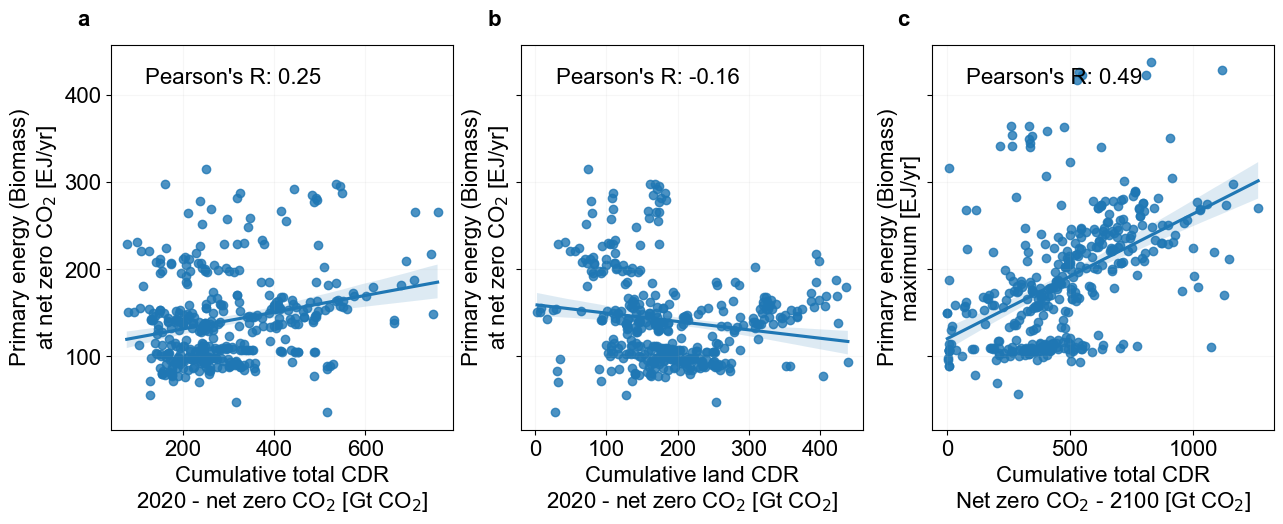

<IPython.core.display.Javascript object>

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.regplot(
    x='total_cdr_2020_netzero',
    y='pe_bio_netzero',
    data=for_plot,
    ax=ax[0]
)
ax[0].set_ylabel('Primary energy (Biomass)\nat net zero CO$_2$ [EJ/yr]')
ax[0].set_xlabel('Cumulative total CDR\n2020 - net zero CO$_2$ [Gt CO$_2$]')
pearson = pearsonr(
    for_plot['total_cdr_2020_netzero'],
    for_plot['pe_bio_netzero']
)
ax[0].annotate(
    f"Pearson's R: {pearson[0].round(2)}",
    xy=(0.1, 0.9),
    xycoords='axes fraction'
)

sns.regplot(
    x='land_cdr_2020_netzero',
    y='pe_bio_netzero',
    data=for_plot,
    ax=ax[1]
)
ax[1].set_ylabel('Primary energy (Biomass)\nat net zero CO$_2$ [EJ/yr]')
ax[1].set_xlabel('Cumulative land CDR\n2020 - net zero CO$_2$ [Gt CO$_2$]')
pearson = pearsonr(
    for_plot['land_cdr_2020_netzero'],
    for_plot['pe_bio_netzero']
)
ax[1].annotate(
    f"Pearson's R: {pearson[0].round(2)}",
    xy=(0.1, 0.9),
    xycoords='axes fraction'
)

sns.regplot(
    x='total_cdr_netzero_2100',
    y='pe_bio_max',
    data=for_plot,
    ax=ax[2]
)
ax[2].set_ylabel('Primary energy (Biomass)\nmaximum [EJ/yr]')
ax[2].set_xlabel('Cumulative total CDR\nNet zero CO$_2$ - 2100 [Gt CO$_2$]')
pearson = pearsonr(
    for_plot['total_cdr_netzero_2100'],
    for_plot['pe_bio_max']
)
ax[2].annotate(
    f"Pearson's R: {pearson[0].round(2)}",
    xy=(0.1, 0.9),
    xycoords='axes fraction'
)

for i, a in enumerate(ax):
    a.grid(alpha=0.1)
    a.annotate(
        string.ascii_lowercase[i],
        xy=(-0.1, 1.05),
        xycoords='axes fraction',
        weight='bold'
    )

In [101]:
fig.savefig(
    Path(
        'figures/SI_fig2.png'
    ),
    dpi=400,
    bbox_inches='tight'
)

<IPython.core.display.Javascript object>